## Purpose
  - Bias를 낮추기위한 Boosting의 초기 모델 AdaBoost 실습 및 해석

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter

In [2]:
# Data Loading - 수술 시 사망 데이터
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [4]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [5]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(f"# of Train data : {len(train_idx)}")
print(f"# of valid data : {len(valid_idx)}")
print(f"# of Train data Y : {Counter(Y.iloc[train_idx])}")
print(f"# of valid data Y : {Counter(Y.iloc[valid_idx])}")

# of Train data : 372
# of valid data : 160
# of Train data Y : Counter({0: 250, 1: 122})
# of valid data Y : Counter({0: 101, 1: 59})


## AdaBoost Parameters
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
  - n_estimators : # of Tree
  - learning_rate : learning_rate과 n_estimator와 Trade-off 관계가 있음
    - Weight applied to each classifier at each boosting iteration

In [6]:
# AdaBoost Hyperparameter
estimators = [70, 90, 100]
learning = [0.01, 0.03, 0.05, 0.1, 0.5]

# Modeling
save_est = []
save_lr = []
f1_score_ = []

cnt = 0
for est in estimators:
    for lr in learning:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print(f"Number of Estimators : {est}, Learning Rate : {lr}")

        model = AdaBoostClassifier(n_estimators=est, learning_rate=lr, random_state=119)
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print(f"Train Acc : {(cm_train[0,0] + cm_train[1,1])/cm_train.sum()}")
        print(f"Train F1-Score : {f1_score(Y.iloc[train_idx], y_pre_train)}")

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print(f"TesT Acc : {(cm_test[0,0] + cm_test[1,1])/cm_test.sum()}")
        print(f"Test F1-Score : {f1_score(Y.iloc[valid_idx], y_pre_test)}")
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_lr.append(lr)
        f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 70, Learning Rate : 0.01
Train Confusion Matrix
[[193  57]
 [  6 116]]
Train Acc : 0.8306451612903226
Train F1-Score : 0.7864406779661016
Test Confusion Matrix
[[76 25]
 [ 4 55]]
TesT Acc : 0.81875
Test F1-Score : 0.7913669064748202
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 70, Learning Rate : 0.03
Train Confusion Matrix
[[201  49]
 [  8 114]]
Train Acc : 0.8467741935483871
Train F1-Score : 0.8
Test Confusion Matrix
[[80 21]
 [ 5 54]]
TesT Acc : 0.8375
Test F1-Score : 0.8059701492537312
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 70, Learning Rate : 0.05
Train Confusion Matrix
[[222  28]
 [ 14 108]]
Train Acc : 0.8870967741935484
Train F1-Score : 0.8372093023255813
Test Confusion Matrix
[[8

In [7]:
print(f">>> {np.argmax(f1_score_)} <<<\nBest Test f1-score : {f1_score_[np.argmax(f1_score_)]}\nBest n_estimators : {save_est[np.argmax(f1_score_)]}\nBest Learning Rate : {save_lr[np.argmax(f1_score_)]}")

>>> 12 <<<
Best Test f1-score : 0.859504132231405
Best n_estimators : 100
Best Learning Rate : 0.05


## 주의

  - 현재는 모델을 Parameter Tuning을 하면서 모델을 저정하지 않고 있음
  - 나중에 Training 시간이 매우 오래 걸리는 알고리즘이면 Parameter Tuning을 하면서 모델을 저장해야함

In [8]:
best_model = AdaBoostClassifier(n_estimators=save_est[np.argmax(f1_score_)], learning_rate=save_lr[np.argmax(f1_score_)], random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print(f"Train Acc : {(cm_train[0,0] + cm_train[1,1])/cm_train.sum()}")
print(f"Train F1-Score : {f1_score(Y.iloc[train_idx], y_pre_train)}")

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print(f"TesT Acc : {(cm_test[0,0] + cm_test[1,1])/cm_test.sum()}")
print(f"Test F1-Score : {f1_score(Y.iloc[valid_idx], y_pre_test)}")

Train Confusion Matrix
[[224  26]
 [ 13 109]]
Train Acc : 0.8951612903225806
Train F1-Score : 0.8482490272373541
Test Confusion Matrix
[[91 10]
 [ 7 52]]
TesT Acc : 0.89375
Test F1-Score : 0.859504132231405


In [9]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

    Score  Feature
0    0.33    event
1    0.14    cd420
2    0.13  preanti
3    0.12    cd496
4    0.10        r
5    0.09      age
6    0.05     wtkg
7    0.04     cd80
8    0.00   zprior
9    0.00      z30
10   0.00  symptom
11   0.00    strat
12   0.00     str2
13   0.00     race
14   0.00   oprior
15   0.00   karnof
16   0.00     homo
17   0.00     hemo
18   0.00   gender
19   0.00    drugs
20   0.00    cd820
21   0.00     cd40


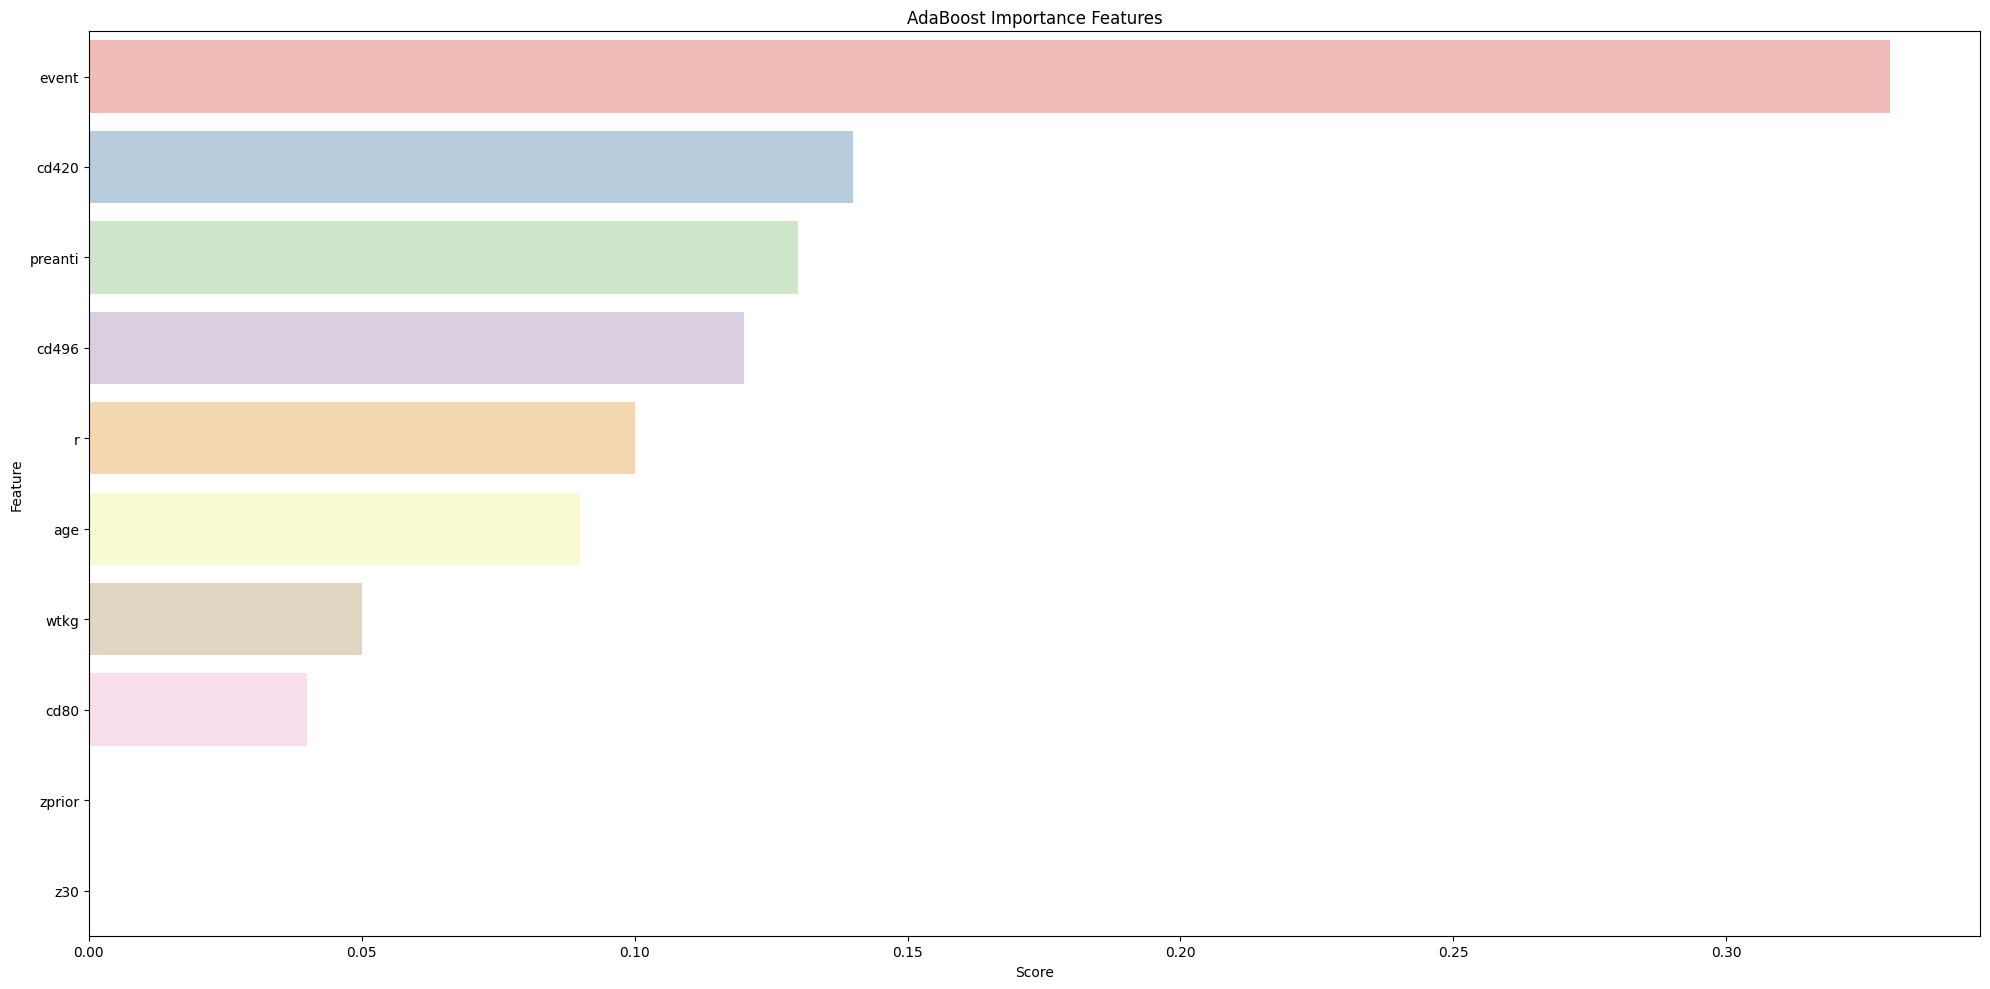

In [10]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40, palette='Pastel1')
plt.title('AdaBoost Importance Features')
plt.tight_layout()
plt.show()